In [2]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [13]:
from data_generation import *
from utils import *
from upscaling import UpScale
from scipy.linalg import sqrtm
import torch
from torch import cuda
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as sn

### Generate high-res data

In [4]:
GP_l = 0.1
GP_sigma = 0.1
N_low = 20
N_high = 100
generate_u_high(1000, GP_l, GP_sigma, N_low, N_high, "high_res_1000.h5","low_res_1000.h5")

100%|██████████| 1000/1000 [1:54:54<00:00,  6.89s/it] 


### Load high-res data

In [5]:
# Loading high-res label
with h5py.File('high_res_1000.h5', 'r') as hf:
    data = hf['high_res'][:]
    
with h5py.File('low_res_1000.h5', 'r') as hf:
    data2 = hf['low_res'][:]

In [14]:
trainset = DataFromH5File("data/high_res_1000.h5","data/low_res_1000.h5")
train_loader = data.DataLoader(dataset=trainset, batch_size=32, shuffle=True)

NameError: name 'DataFromH5File' is not defined

In [7]:
N_low = 20
N_high = 100
batch_size = 32

K = 100
s = 0.05

GP_l = 0.1
GP_sigma = 0.1

ll_sigma = 0.1

epoch_num = 1000

w_low, r_low, A_low, x_low, y_low = generate_data(N_low)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high)

mean_u, covariance_u = u_low_prior(GP_l,GP_sigma,N_low)

### Check the mean of u_high labels

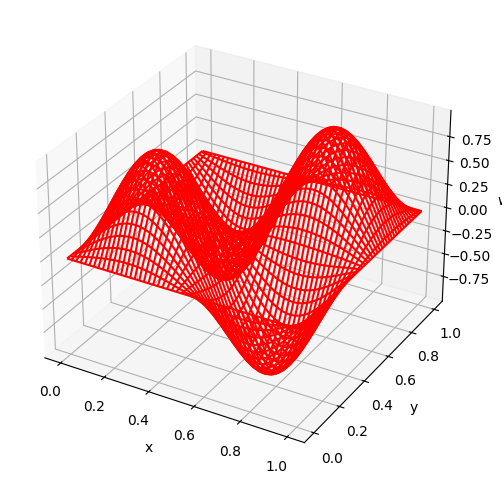

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_high, y_high)
ax.plot_wireframe(X, Y, data.mean(axis=0),color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()

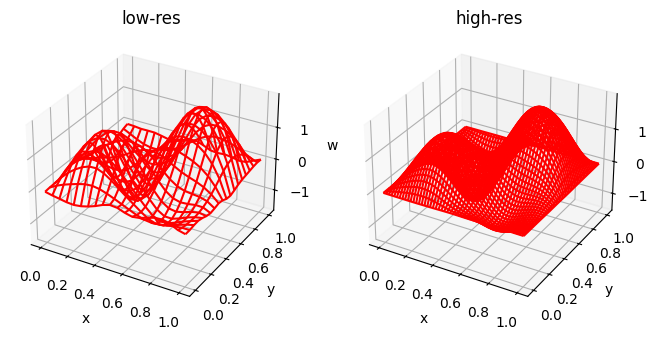

In [11]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, data2[0],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, data[0],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

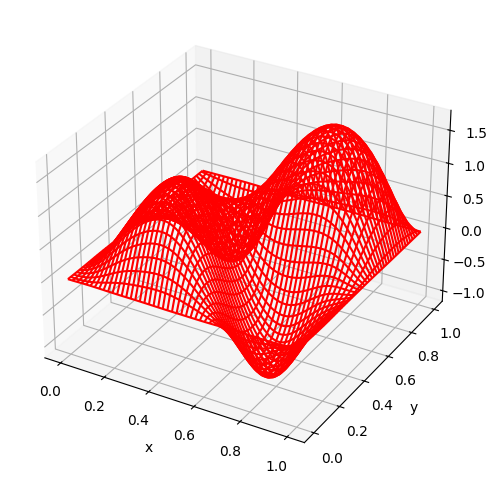

In [16]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_high, y_high)
ax.plot_wireframe(X, Y, data[100],color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()

In [7]:
data.mean(axis=0).max()

0.9813643165091541

### Check whether sampling from r == sampling from u_prior

In [33]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low)

h_low = 1/N_low

G = gaussian_kernal(x_low,y_low,GP_l,GP_sigma,N_low)

r_low_sample = np.random.multivariate_normal(r_low.ravel(),G)
    

for i in tqdm(range(10)):
    r_low_sample = np.random.multivariate_normal(r_low.ravel(),G)
    
    C = np.linalg.solve(A_low,r_low_sample)
    w_low_sample = C.reshape((N_low,N_low))
    
    if i == 0:
        total = w_low_sample.reshape(1,w_low.shape[0],-1)
    else:
        total = np.concatenate([total,w_low_sample.reshape(1,w_low.shape[0],-1)],axis=0)

100%|██████████| 1000/1000 [00:19<00:00, 52.22it/s]


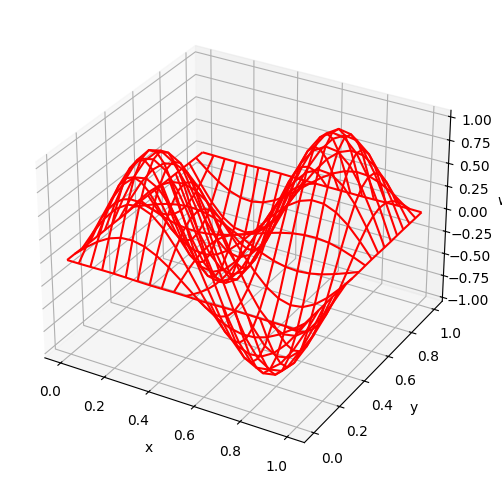

In [34]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax.plot_wireframe(X, Y, total.mean(axis=0),color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()